**Užduotį atliko:**
Pijus Zlatkus 2110648

## Užduoties variantas:

**Klasių rinkinys:** Auksinė žuvelė (Goldfish), Meduza (Jellyfish), Jūrų žvaigždė (Starfish)

### Konfigūracija užduočiai atlikti

In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import transforms
import PIL
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### Duomenų užkrovimas

Klasifikavimo modeliui kurti naudojamos nuotraukų transformacijos. Pirmiausiai yra suvienodinamos nuotraukos ir tik tada paverčiamos į tenzorius. Taip pat yra naudojama normalizacija, kurios reikšmės yra rastos naudoojant kodą pateiktą žemiau.

In [4]:
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3200, 0.3404, 0.3805], std=[0.2891, 0.2468, 0.2806]),
])

Kiekvienas duomenų rinkinys yra užkraunamas iš skirtingų aplankų, kuriuose yra nuotraukos.

In [5]:
train_dataset = datasets.ImageFolder(root='train', transform=transform)
validation_dataset  = datasets.ImageFolder(root='validation', transform=transform)
test_dataset = datasets.ImageFolder(root='test', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=0)

Šis kodas ieško vidurkių ir jų standartinių nuokrypių, kurie reikalingi nuotraukų normalizavimui.

In [41]:
dataset = datasets.ImageFolder(root='data', transform=transform)
dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=0)

mean = torch.zeros(3)
total_images = 0

total_images = 0

for images, _ in validation_loader:
    batch_samples = images.size(0)  # Number of images in the batch
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    total_images += batch_samples

mean /= total_images

var = torch.zeros(3)
for images, _ in validation_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0, 2])

var /= (total_images * 256 * 256)
std = torch.sqrt(var)

print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([0.3200, 0.3404, 0.3805])
Std: tensor([0.2891, 0.2468, 0.2806])


**Kodas skirtas patikrinti kaip pasikeičia nuotraukos:**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


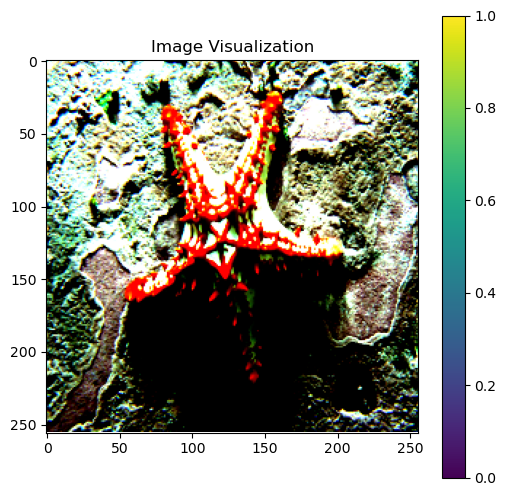

In [46]:
images, labels = next(iter(train_loader))
first_image = images[0]

first_image = first_image.permute(1, 2, 0)

plt.figure(figsize=(6,6))
plt.imshow(first_image.numpy())
plt.colorbar()
plt.title("Image Visualization")
plt.show()

## Nenaudojami (blogi) konvoliucinių tinklų modeliai

Šie 2 modeliai buvo apmokinami kaip pirmi variantai, tačiau toliau ieškant kaip galima būtų juos patobulinti liko nebenaudojami. Pirmas konvoliucinis neuroninis tinklas buvo paimtas iš pateiktos medžiagos ir truputį pakoreguotas. Keičiant hyperparametrus nedaug keitėsi rezultatai, tad buvo modelį labiau supaprastinti ir sumažinti parametrų kiekį.

In [120]:
class GJS_CNN_1(nn.Module):
    def __init__(self):
        super(GJS_CNN_1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding='same')

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)

        self.fc1 = nn.Linear(256 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 3)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)

        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = self.flatten(x)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class GJS_CNN_2(nn.Module):
    def __init__(self):
        super(GJS_CNN_2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)

        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 3)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)

        x = self.flatten(x)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Naudojamas konvoliucinis neuroninio tinklo modelis

Apmokinant modelį buvo pastebėta, kad modelis persimokino todėl buvo panaudota `dropout` funkcija ir padidintas parametrų kiekis paskutiniame sluoksnyje.

In [27]:
# GoldfishJellyfishStarfish Konvoliucinis neuroninis tinklas
class GJS_CNN(nn.Module):
    def __init__(self):
        super(GJS_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 3)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout1(x)

        x = self.flatten(x)
        x = self.dropout2(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = GJS_CNN()
print(model)

GJS_CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)


Parametrų skaičius

In [28]:
number = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("number of unknown parameters: {}".format(number))

number of unknown parameters: 33580067


Tikslo funkcija su optimizavimo metodu.

In [29]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, amsgrad=True)

## Modelio apmokinimas

Buvo net tik statiškai kontroliuoti epochų skaičių, bet ir dinamiškai naudojant ankstyvo sustojimo (angl. early stop) metodą. Modelis pirmiausiai yra apmokinamas naudojant apmokinimo duomenų rinkinį, o po to tikrinamas jo tikslumas ir patikimumas su validacijai skirtais duomenimis. Galiausiai nustojus mokinti modelį yra patikrinamas modelio tikslumas su testavimui skirtu duomenų rinkiniu.

In [30]:
# Nustatomas epochų skaičius (mokymo ciklų skaičius)
n_epochs = 30
# Perkeliamas modelis į tinkamą įrenginį (CPU ar GPU)
model.to(device)

# Sukuriami sąrašai mokymo ir validacijos paklaidų bei tikslumo laikymui
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

# Nustatomas ankstyvo sustojimo kantrybės (tolerancijos) lygis
early_stopping_patience = 3
early_stopping_counter = 0
best_val_loss = np.inf

for epoch in range(0, n_epochs+1):
    model.train()

    train_loss = 0.0
    validation_loss = 0.0
    train_acc = 0.0
    validation_acc = 0.0

    # Nulinėje epochoje išjungiamas gradientų skaičiavimas
    if epoch == 0:
      torch.set_grad_enabled(False)

    # Apmokymas
    for data in train_loader:
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(images)

        with torch.no_grad():
            outputLabels = torch.argmax(outputs, 1)
            accuracy = labels == outputLabels
            train_acc += torch.sum(accuracy.float()).item()

        loss = loss_func(outputs, labels)

        # Jei ne nulinė epocha, atnaujiname modelį
        if epoch != 0:
            loss.backward()     # Atnaujinami gradientai
        optimizer.step()    # Atnaujinamos svorių reikšmės

        train_loss += loss.item() * images.size(0)

    # Validacija
    model.eval()
    with torch.no_grad():
      for data in validation_loader:
          images, labels = data[0].to(device), data[1].to(device)
          outputs = model(images)
          loss = loss_func(outputs, labels)
          validation_loss += loss.item() * images.size(0)

          outputLabels = torch.argmax(outputs, 1)
          accuracy = labels == outputLabels
          validation_acc += torch.sum(accuracy.float()).item()

    # Apskaičiuojami vidutiniai mokymo ir validacijos paklaidų bei tikslumo rodikliai
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_val_loss = validation_loss / len(validation_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    avg_val_acc = validation_acc / len(validation_loader.dataset)

    # Įrašomi epochos rezultatai į sąrašus
    train_losses.append(avg_train_loss)
    validation_losses.append(avg_val_loss)
    train_accuracies.append(avg_train_acc)
    validation_accuracies.append(avg_val_acc)

    print('Epoch: {} \t Training Loss: {:.10f} \t Training Accuracy: {:.5f} \t Validation Loss: {:.10f} \t Validation Accuracy: {:.5f}'.format(
        epoch,
        avg_train_loss,
        avg_train_acc,
        avg_val_loss,
        avg_val_acc,
        ))
    
    # Tikrinama ankstiniam mokymosi stabdymui
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered. Stopping training...")
            break
    
    if epoch == 0:
      torch.set_grad_enabled(True)

# Testavimas
test_loss = 0.0
test_acc = 0.0

model.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        loss = loss_func(outputs, labels.squeeze())
        
        test_loss += loss.item() * images.size(0)

        outputLabels = torch.argmax(outputs, 1)
        accuracy = labels == outputLabels
        test_acc += torch.sum(accuracy.float()).item()

avg_test_loss = test_loss / len(test_loader.dataset)
avg_test_acc = test_acc / len(test_loader.dataset)

print('Testing loss (unseen data): {:.10f} \t Testing accuracy: {:.5f}'.format(
    avg_test_loss, avg_test_acc
))

Epoch: 0 	 Training Loss: 1.0999664091 	 Training Accuracy: 0.32522 	 Validation Loss: 1.1006112541 	 Validation Accuracy: 0.27545
Epoch: 1 	 Training Loss: 1.0591934431 	 Training Accuracy: 0.60051 	 Validation Loss: 0.7192995652 	 Validation Accuracy: 0.68263
Epoch: 2 	 Training Loss: 0.7045114782 	 Training Accuracy: 0.67222 	 Validation Loss: 0.7096276754 	 Validation Accuracy: 0.63473
Epoch: 3 	 Training Loss: 0.6158469678 	 Training Accuracy: 0.71447 	 Validation Loss: 0.6790551390 	 Validation Accuracy: 0.71856
Epoch: 4 	 Training Loss: 0.5540291422 	 Training Accuracy: 0.77337 	 Validation Loss: 0.7375509889 	 Validation Accuracy: 0.67066
Epoch: 5 	 Training Loss: 0.4567931977 	 Training Accuracy: 0.82971 	 Validation Loss: 0.7413005904 	 Validation Accuracy: 0.64072
Epoch: 6 	 Training Loss: 0.3765042594 	 Training Accuracy: 0.85147 	 Validation Loss: 0.6590525304 	 Validation Accuracy: 0.74850
Epoch: 7 	 Training Loss: 0.3156123638 	 Training Accuracy: 0.88220 	 Validation Lo

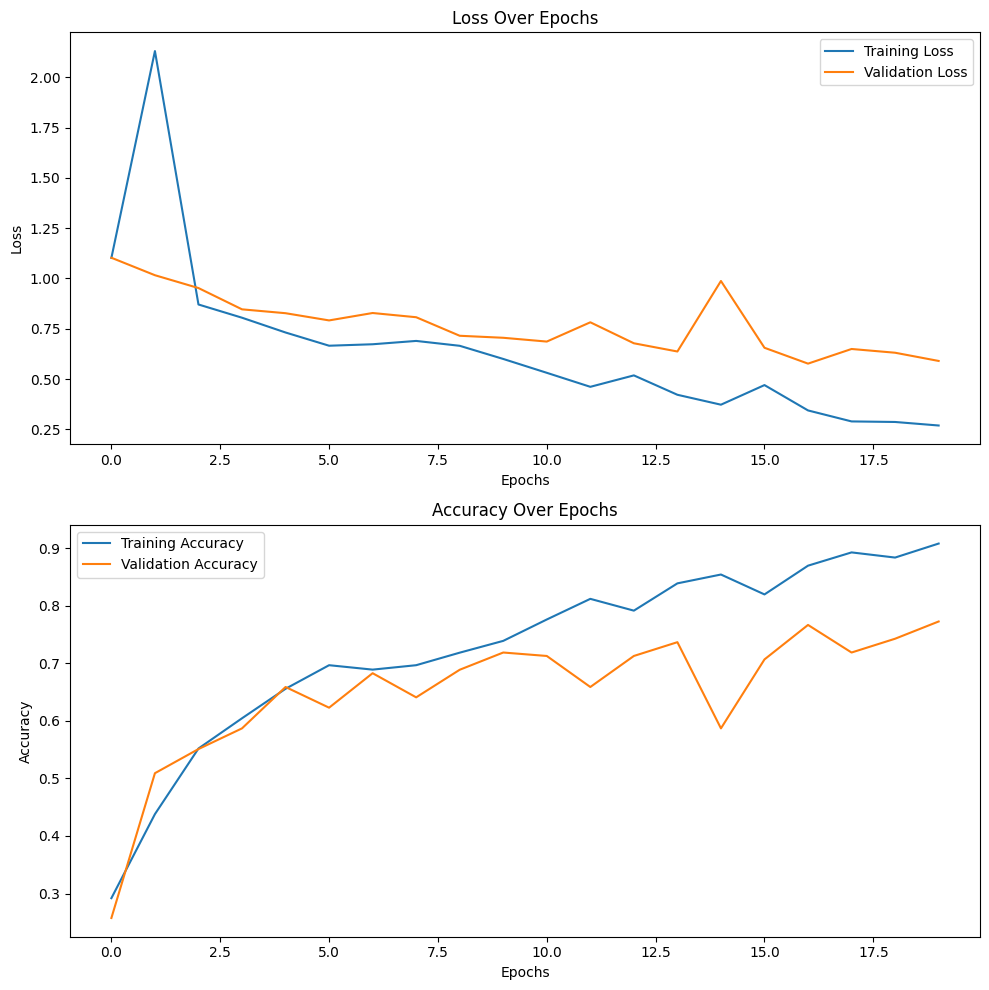

In [138]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(validation_losses, label='Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss Over Epochs')
axs[0].legend()

axs[1].plot(train_accuracies, label='Training Accuracy')
axs[1].plot(validation_accuracies, label='Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy Over Epochs')
axs[1].legend()

plt.tight_layout()
plt.show()

## Modelio išsaugojimas ir užkrovimas

In [56]:
torch.save(model.state_dict(), "model.pth")

In [8]:
test_model = GJS_CNN()
test_model.load_state_dict(torch.load("model.pth"))
test_model.to(device)
test_model

GJS_CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)

Kodas dar kartą pratestuoti modelį ant testavimui skirto duomenų rinkinio

In [9]:
# Testavimas
test_loss = 0.0
test_acc = 0.0

test_model.to(device)
test_model.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = test_model(images)
        loss = loss_func(outputs, labels.squeeze())
        
        test_loss += loss.item() * images.size(0)

        outputLabels = torch.argmax(outputs, 1)
        accuracy = labels == outputLabels
        test_acc += torch.sum(accuracy.float()).item()

avg_test_loss = test_loss / len(test_loader.dataset)
avg_test_acc = test_acc / len(test_loader.dataset)

print('Testing loss (unseen data): {:.10f} \t Testing accuracy: {:.5f}'.format(
    avg_test_loss, avg_test_acc
))

Testing loss (unseen data): 0.2527337760 	 Testing accuracy: 0.92308


## Statistikos apskaičiavimas

Skaičiuojamos šios metrikos: klasifikavimo matrica, tikslumas, precizija, atkūrimas ir F1.

Classification Report:
              precision    recall  f1-score   support

    goldfish       0.93      0.95      0.94        57
   jellyfish       0.94      0.93      0.93        69
    starfish       0.88      0.88      0.88        43

    accuracy                           0.92       169
   macro avg       0.92      0.92      0.92       169
weighted avg       0.92      0.92      0.92       169

Accuracy: 0.92308
Precision: 0.92314
Recall: 0.92308
F1 Score: 0.92306

Confusion Matrix:
[[54  1  2]
 [ 2 64  3]
 [ 2  3 38]]


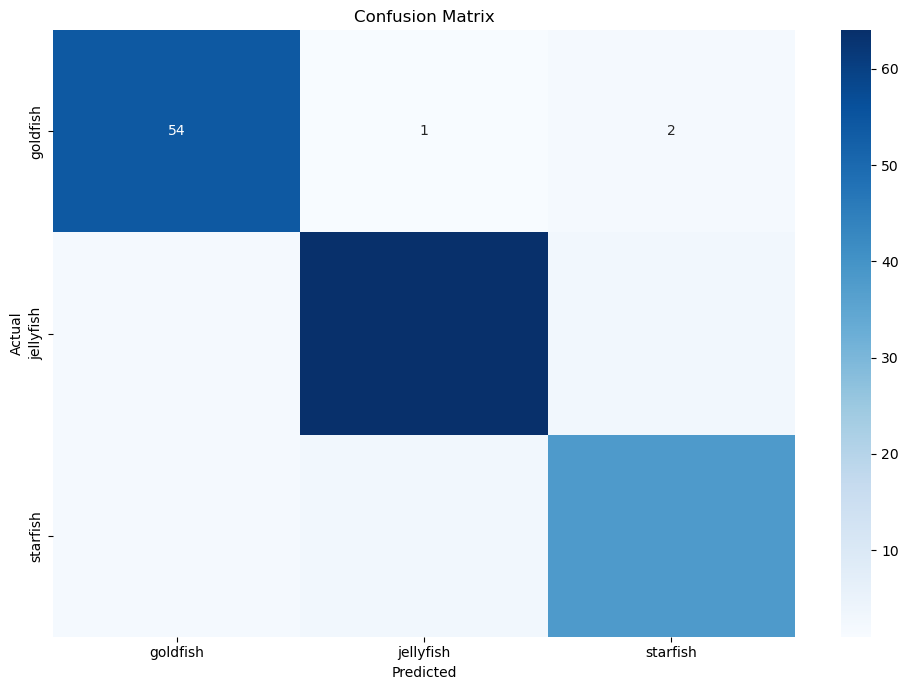

In [10]:
test_model.eval()

predicted_classes = []
true_classes = []

# Patikrinamas modelis
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = test_model(inputs)
        _, preds = torch.max(outputs, 1)
        predicted_classes.extend(preds.cpu().numpy())
        true_classes.extend(labels.cpu().numpy())

class_labels = list(test_loader.dataset.class_to_idx.keys())

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Apskaičiuojamos metrikos
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1 Score: {f1:.5f}")

# Klasifikavimo matrica
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

# Matricos atvaizdavimas
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix') 

plt.tight_layout()
plt.show()